In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as st
import arviz as az
import theano
import theano.tensor as tt
from theano.ifelse import ifelse
from math import cos, pi
from pymc3.distributions.dist_math import bound

- Link to the code for the book https://sites.google.com/site/doingbayesiandataanalysis/software-installation/DBDA2Eprograms.zip?attredirects=0&d=1

- Find BernMetrop.R in the archive, read it to have an idea what it does. It actually implements the Metropolis algorithm for Fig. 7.4 in R (1D Bernoulli problem)

**Exercise 7.3. [Purpose: Using a multimodal prior with the Metropolis
algorithm, and seeing how chains can transition across modes or get stuck
within them.]**

In this exercise, you will see that the Metropolis algorithm operates
with multimodal distributions.

**(A)** Consider a prior distribution on coin bias that puts most credibility at 0.0, 0.5,
and 1.0, which we will formulate as $p(\theta) = (\cos(4\pi\theta) + 1)^2 /1.5$.

*A (nothing to be done, just understand)*

**(B)** Make a plot of the prior. *Hint: `theta = seq(0,1,length=501) ; plot
(theta , (cos(4*pi*theta)+1) ˆ 2/1.5 )`*

*B (make a plot of the prior, for example using grid approximation scripts we did for pymc3)*

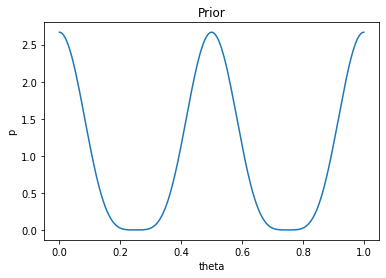

In [2]:
def prior(t):
    return (cos(4*pi*t) + 1)**2/1.5

t = np.linspace(0, 1, num=1000)
plt.plot(t, np.vectorize(prior)(t))
plt.xlabel('theta')
plt.ylabel('p')
plt.title('Prior')
plt.show()

**(C)** In the script BernMetrop.R , find the function definition that specifies the prior
distribution. Inside that function definition, comment out the line that assigns a beta
density to `pTheta`, and instead put in a trimodal prior like this:
```R
#pTheta = dbeta( theta , 1 , 1 )
pTheta = (cos(4*pi*theta)+1)ˆ2/1.5
```
To have the Metropolis algorithm explore the prior, we give it empty data. Find the
line in the script that specifies the data and set myData = c() . Run the script, using a
proposal SD=0.2. Include the graphical output in your write-up. Does the histogram of
the trajectory look like the graph of the previous part of the exercise?

*C/D/E: You do not need to  implement Metropolis in PyMC3 (check this week’s notebook how we can use the ready made). Recode the 1D Bernoulli model in PyMC3, and use the Metropolis sampler, with the multimodal prior given in the exercise. Plot and compare traceplots for different standard deviations of the proposal distribution.*

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [theta]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:01<00:00, 6392.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


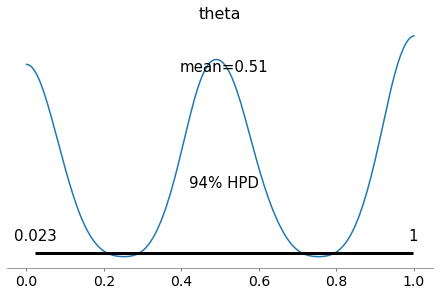

In [3]:
def custom_prior(name='custom_prior', *args, **kwargs):
    def prior(t):
        return (pm.math.cos(4*pi*t) + 1)**2/1.5
    def bound(t, lower=0.0, upper=0.0):
        return tt.switch(tt.lt(t, 0), -np.inf, tt.switch(tt.gt(t, 1), -np.inf, t))
    def logp(t):
        # Note, that this logp function kills the NUTS sampler, when initials are not set within the domain
        # Maybe see https://discourse.pymc.io/t/getting-bad-initial-energy-inf-when-trying-to-sample-simple-model/364
        return pm.math.log(prior(bound(t, lower=0.0, upper=0.0)))
    return pm.DensityDist(name=name, logp=logp, *args, **kwargs)

with pm.Model():
    custom_prior(name="theta")
    sample = pm.sample(
        5000,
        step=pm.step_methods.metropolis.Metropolis(),
        tune=500
    )
    pm.plot_posterior(sample)

Sequential sampling (1 chains in 1 job)
Metropolis: [theta]
Sampling chain 0, 0 divergences: 100%|██████████| 10500/10500 [00:01<00:00, 6391.99it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/martoko/.local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


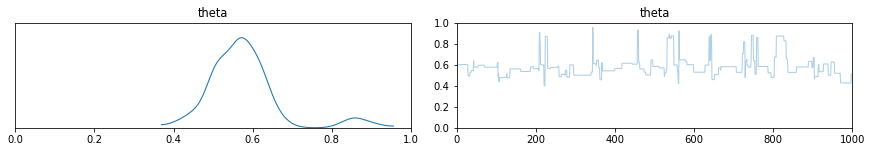

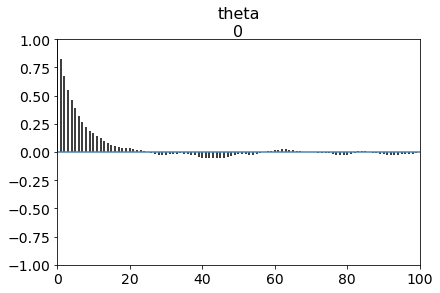

In [4]:
with pm.Model() as model:
    D = np.concatenate([np.repeat(0,6), np.repeat(1,14)])
    theta = custom_prior(name="theta")
    y = pm.Bernoulli(name="obs", p=theta, observed=D)
    sample = pm.sample(
            10000, # increase for more trustworthy results (we show small numbers to visualize the impact of the initial seed)
            step=pm.step_methods.metropolis.Metropolis(),
            chains = 1,  # Like in Fig. 7.10 we only plot 3 chains (normallly at least 4 is recommended, which is the default)
            start = [{ "theta": 0.01 }], # 3 starting points as in Fig. 7.10
            discard_tuned_samples = True, # Show the burn-in prefix like in Fig. 7.10
            tune = 500
    )
    
    ax = pm.traceplot(sample)
    ax[0,0].axis([0.0, 1.0, 0.0, 7.0])
    ax[0,1].axis([0,1000,0.0, 1.0,]) # clip the trace plot (to the right, to show the entire development better)
    plt.show()
    
    pm.autocorrplot(sample)
    plt.show()

In [5]:
    az.summary (sample)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
theta  0.578  0.093   0.425    0.845      0.003    0.002     940.0   921.0   

       ess_bulk  ess_tail  r_hat  
theta     896.0     759.0    NaN

**(D)** Repeat the previous part but now with `myData = c(0,1,1)`. Include the
graphical output in your write-up. Does the posterior distribution make sense? Explain
why.

Sequential sampling (1 chains in 1 job)
Metropolis: [theta]
Sampling chain 0, 0 divergences: 100%|██████████| 5500/5500 [00:00<00:00, 6565.96it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/martoko/.local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


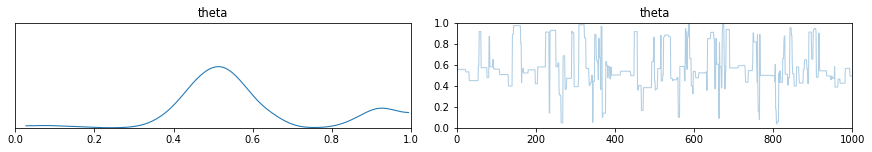

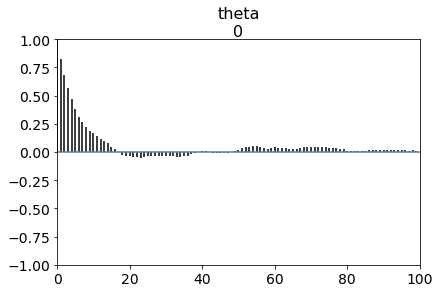

In [6]:
with pm.Model() as model:
    D = [0,1,1]
    theta = custom_prior(name="theta")
    y = pm.Bernoulli(name="obs", p=theta, observed=D)
    sample = pm.sample(
            5000, # increase for more trustworthy results (we show small numbers to visualize the impact of the initial seed)
            step=pm.step_methods.metropolis.Metropolis(),
            chains = 1,  # Like in Fig. 7.10 we only plot 3 chains (normallly at least 4 is recommended, which is the default)
            start = [{ "theta": 0.01 }], # 3 starting points as in Fig. 7.10
            discard_tuned_samples = True, # Show the burn-in prefix like in Fig. 7.10
            tune = 500
    );
    
    ax = pm.traceplot(sample)
    ax[0,0].axis([0.0, 1.0, 0.0, 7.0])
    ax[0,1].axis([0,1000,0.0, 1.0,]) # clip the trace plot (to the right, to show the entire development better)
    plt.show()
    
    pm.autocorrplot(sample)
    plt.show()

In [7]:
    az.summary (sample)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
theta  0.575  0.18   0.382    0.973      0.008    0.006     490.0   459.0   

       ess_bulk  ess_tail  r_hat  
theta     526.0     512.0    NaN

**(E)** Repeat the previous part but now with proposal $SD=0.02$. Include the graphical
output in your write-up. Does the posterior distribution make sense? Explain why not;
what has gone wrong? If we did not know from the previous part that this output was
unrepresentative of the true posterior, how could we try to check? Hint: See next part.

Sequential sampling (1 chains in 1 job)
Metropolis: [theta]
Sampling chain 0, 0 divergences: 100%|██████████| 5500/5500 [00:00<00:00, 6046.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/martoko/.local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


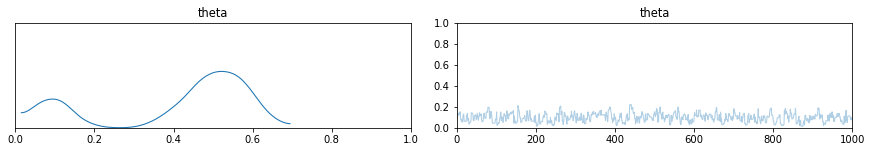

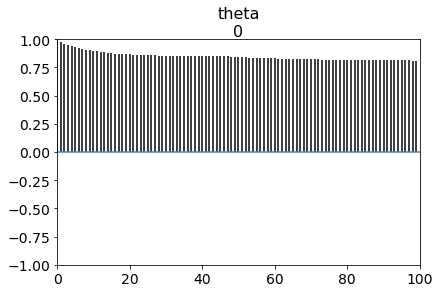

In [8]:
with pm.Model() as model:
    D = [0,1,1]
    theta = custom_prior(name="theta")
    y = pm.Bernoulli(name="obs", p=theta, observed=D)
    sample = pm.sample(
            5000, # increase for more trustworthy results (we show small numbers to visualize the impact of the initial seed)
            step=pm.step_methods.metropolis.Metropolis(S=np.array([0.02])),
            chains = 1,  # Like in Fig. 7.10 we only plot 3 chains (normallly at least 4 is recommended, which is the default)
            start = [{ "theta": 0.01 }], # 3 starting points as in Fig. 7.10
            discard_tuned_samples = True, # Show the burn-in prefix like in Fig. 7.10
            tune = 500
    );
    
    ax = pm.traceplot(sample)
    ax[0,0].axis([0.0, 1.0, 0.0, 7.0])
    ax[0,1].axis([0,1000,0.0, 1.0,]) # clip the trace plot (to the right, to show the entire development better)
    plt.show()
    
    pm.autocorrplot(sample)
    plt.show()

In [9]:
    az.summary (sample)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
theta  0.412  0.189   0.044    0.623      0.115    0.092       3.0     3.0   

       ess_bulk  ess_tail  r_hat  
theta       4.0      15.0    NaN

**(F)** Repeat the previous part but now with the initial position at 0.99: `trajectory[1] = 0.99`. In conjunction with the previous part, what does this result tell us?

*F: see this week’s notebook how we seed the chains with initial positions.*

Sequential sampling (1 chains in 1 job)
Metropolis: [theta]
Sampling chain 0, 0 divergences: 100%|██████████| 5500/5500 [00:00<00:00, 6464.78it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/martoko/.local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


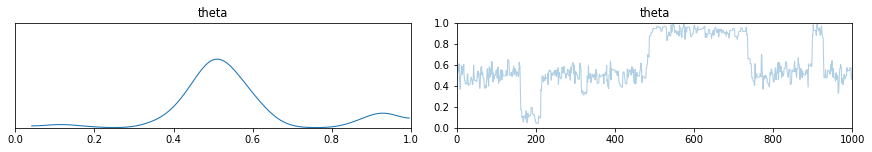

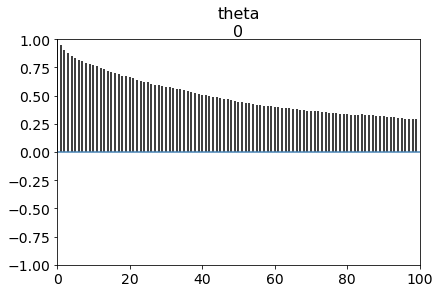

In [10]:
with pm.Model() as model:
    D = [0,1,1]
    theta = custom_prior(name="theta")
    y = pm.Bernoulli(name="obs", p=theta, observed=D)
    sample = pm.sample(
            5000, # increase for more trustworthy results (we show small numbers to visualize the impact of the initial seed)
            step=pm.step_methods.metropolis.Metropolis(S=np.array([0.02])),
            chains = 1,  # Like in Fig. 7.10 we only plot 3 chains (normallly at least 4 is recommended, which is the default)
            start = [{ "theta": 0.99 }], # 3 starting points as in Fig. 7.10
            discard_tuned_samples = True, # Show the burn-in prefix like in Fig. 7.10
            tune = 500
    );
    
    ax = pm.traceplot(sample)
    ax[0,0].axis([0.0, 1.0, 0.0, 7.0])
    ax[0,1].axis([0,1000,0.0, 1.0,]) # clip the trace plot (to the right, to show the entire development better)
    plt.show()
    
    pm.autocorrplot(sample)
    plt.show()